## Sentinel-2 Level 2 stage-in

### Search parameters

Define the series

In [1]:
series = 'https://catalog.terradue.com/sentinel2/description'

Define the area of interest as a bounding box

In [30]:
lon_min = -6.98302225
lat_min = 36.58
lon_max = -5.8422666
lat_max = 37.49

In [31]:
bbox = '%s,%s,%s%s' % (lon_min, 
                      lat_min,
                      lon_max,
                      lat_max)  

Define the time of interest

In [3]:
start_date = '2017-09-01T00:00:00'
stop_date = '2017-09-10T23:59:59'

### Import the required modules

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

sys.path.append('/opt/OTB-6.2.0/lib/python')
sys.path.append('/opt/OTB-6.2.0/lib/libfftw3.so.3')
os.environ['OTB_APPLICATION_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
os.environ['LD_LIBRARY_PATH'] = '/opt/OTB-6.2.0/lib'
os.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
os.environ['GDAL_DATA'] = '/opt/anaconda/share/gdal/'
import otbApplication

import gc

### Stage-in folder

In [5]:
tmp_dir = '/workspace/data'

In [6]:
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)

### Build and submit the catalog search

Define all the search parameters

In [7]:
search_params = dict([('bbox', bbox),
                     ('start', start_date),
                     ('stop', stop_date),
                     ('pt', 'S2MSI2Ap')])

Submit the query to the catalogue

In [8]:
search = ciop.search(end_point=series,
                     params=search_params,
                     output_fields='enclosure,identifier', 
                     model='GeoTime')

In [9]:
for index, elem in enumerate(search):
    print(index, elem['identifier'])

(0, 'S2A_MSIL2A_20170909T110651_N0205_R137_T30STF_20170909T111217')
(1, 'S2A_MSIL2A_20170909T110651_N0205_R137_T29SQA_20170909T111217')
(2, 'S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217')
(3, 'S2A_MSIL2A_20170909T110651_N0205_R137_T29SPA_20170909T111217')
(4, 'S2A_MSIL2A_20170909T110651_N0205_R137_T30STG_20170909T111217')
(5, 'S2A_MSIL2A_20170909T110651_N0205_R137_T29SQB_20170909T111217')
(6, 'S2A_MSIL2A_20170902T112111_N0205_R037_T29SPB_20170902T112431')


### Stage-in the data

Select the index of the returned results

In [44]:
s2_index = 2

Stage-in the data or if it's already staged-in only set the *retrieved* variable

In [45]:
try:
    retrieved = ciop.copy(search[s2_index]['enclosure'], tmp_dir)
except:
    retrieved = os.path.join(tmp_dir, search[s2_index]['identifier'])

Split into a path and an identifier

In [46]:
data_path = os.path.split(retrieved)[0]
s2_identifier = os.path.split(retrieved)[1]
s2_identifier

'S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217'

### Create and plot  the RGB composites

Search for the granule(s) in the Sentinel-2 product

In [47]:
granule_path = os.path.join(data_path, s2_identifier, s2_identifier + '.SAFE', 'GRANULE')
os.chdir(granule_path)

In [48]:
granules = [ name for name in os.listdir('.') if os.path.isdir(name)]

granules

['L2A_T29SPB_A011574_20170909T111217']

In [49]:
granule_index = 0

Search for the band 2, 3, 4 and 8 image data

In [50]:
s2_bands = []

for band in [2, 3, 4, 8]:

    search_expression = os.path.join(granule_path, granules[granule_index], 'IMG_DATA', 'R10m', '*_B0' + str(band) + '_10m.jp2')
    s2_bands.append(glob.glob(search_expression)[0])

Use OTB to rescale the data to the 0-255 range

In [51]:
results = []

for index, item in enumerate(s2_bands, start = 0):
    print(item)
    app = otbApplication.Registry.CreateApplication("Rescale")
    app.SetParameterString("in", item)
    app.SetParameterFloat("outmin", 0)
    app.SetParameterFloat("outmax", 255)
    app.Execute()
    
    result = app.GetVectorImageAsNumpyArray("out")
    results.append(result.astype(np.uint8))

/workspace/data/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217.SAFE/GRANULE/L2A_T29SPB_A011574_20170909T111217/IMG_DATA/R10m/L2A_T29SPB_20170909T110651_B02_10m.jp2
/workspace/data/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217.SAFE/GRANULE/L2A_T29SPB_A011574_20170909T111217/IMG_DATA/R10m/L2A_T29SPB_20170909T110651_B03_10m.jp2
/workspace/data/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217.SAFE/GRANULE/L2A_T29SPB_A011574_20170909T111217/IMG_DATA/R10m/L2A_T29SPB_20170909T110651_B04_10m.jp2
/workspace/data/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217/S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217.SAFE/GRANULE/L2A_T29SPB_A011574_20170909T111217/IMG_DATA/R10m/L2A_T29SPB_20170909T110651_B08_10m.jp2


Define the composites

In [52]:
img_432 = np.dstack((results[2], results[1], results[0]))
img_843 = np.dstack((results[3], results[2], results[1]))

rgbs = [img_432, img_843]
rgbs_caption = ['Sentinel-2 true colour composite', 'Sentinel-2 false color Infrared composite']

Plot the composites

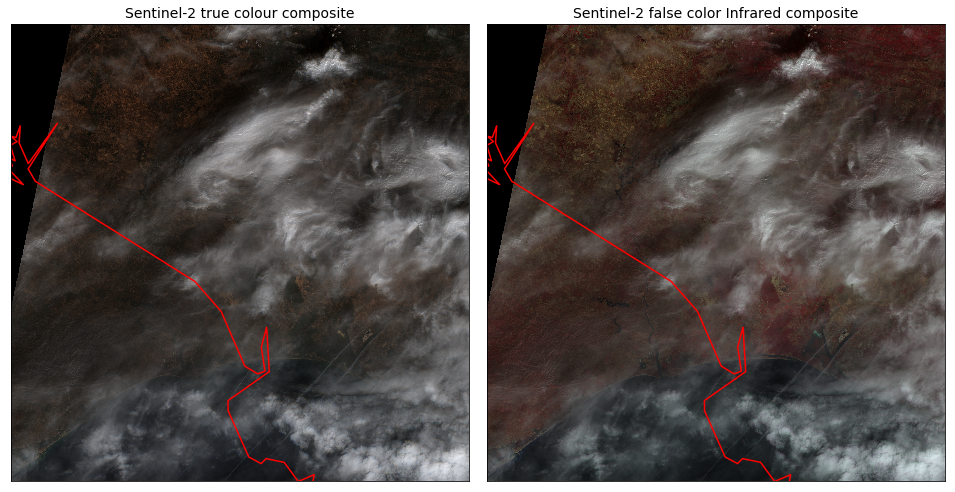

7022

In [53]:
fig = plt.figure(figsize=(20,20)) 
i = 1
for rgb in rgbs:
    ax = fig.add_subplot(330+i) 
    ax.set_title(rgbs_caption[i-1], fontsize=14)
    i = i + 1
    map = Basemap(projection = 'merc',
              llcrnrlat = lat_min,
              urcrnrlat = lat_max,
              llcrnrlon = lon_min,
              urcrnrlon = lon_max,
              resolution='i',
              ax=ax)

    map.imshow(rgb, origin='upper', ax=ax)
    map.drawcountries(color='blue', linewidth=1.5, ax=ax)
    map.drawcoastlines(linewidth=1.5, color='red', ax=ax)

plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.clf()
gc.collect()